# 重新实现之前的线性热模型
应该只需要读取第一次实验的数据，这里主要想规范一下之前的写法

In [1]:
import pandas as pd
import numpy as np
import os
from keys import *
import math

from tqdm import tqdm
from loader import Loader
from thermal_model.data import *
from thermal_model.configs import *
from thermal_model.figure_plotter import *
from utils_thermal_model_raw_process import *
import matplotlib.pyplot as plt
from plotter import Plotter
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lars
from sklearn.ensemble import RandomForestRegressor
from thermal_model.thermal_model import fit_random_forest, model_estimator,fit_LARS
import pickle
import math
from thermal_model.electrolyzer import Electrolyzer
from thermal_model.original_thermal_model_and_plotter_0117 import cooling_Power_Qlye



# 读取数据并且缓存成单独pickle

In [ ]:
df_thermal_model_data_raw = ThermalModelData().load()

# 生成线性模型的输入项

In [ ]:
df_thermal_model_data_input = generate_model_input(df_thermal_model_data_raw)

In [ ]:
df_thermal_model_data_input.columns

# 生成模型（应该使用线性模型）

In [ ]:
model_random_forest,model_input,model_target = fit_random_forest(df_thermal_model_data_input,6)

In [ ]:
( model_predict, error) = model_estimator(
    model_random_forest,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="随机森林",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="随机森林"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict
).save()

In [ ]:
model_lars,model_input,model_target = fit_LARS(df_thermal_model_data_input)

In [ ]:
( model_predict, error) = model_estimator(
    model_lars,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="LARS",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="LARS"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict,
    title_model='LARS'
).save()

# 测试模型功能

In [8]:
class Model_efficiency_hydrogen_cost(QuadroPlotter):
    def __init__(
        self, 
        label="Thermal model", 
        title="不同工况下的电解槽高热值热效率与制氢能耗", 
        num_subplot=4, 
        title_plot=False
    ) -> None:
        """里面的1、3分别留给高热值热效率，2、4留给

        Args:
            label (str, optional): _description_. Defaults to "Thermal model".
            title (str, optional): _description_. Defaults to "不同工况下的电解槽高热值热效率与制氢能耗".
            num_subplot (int, optional): _description_. Defaults to 4.
            title_plot (bool, optional): _description_. Defaults to False.
        """
        super().__init__(label, title, num_subplot, title_plot)
        self.electrolyzer = Electrolyzer()
    
    def plot_1(self):
        lye_temperature_range = range(
            OperatingRange.Contour.Lye_temperature.left,
            OperatingRange.Contour.Lye_temperature.right,
            OperatingRange.Contour.Lye_temperature.step
        )
        current_range = range(
            OperatingRange.Contour.Current.left,
            OperatingRange.Contour.Current.right,
            OperatingRange.Contour.Current.step
        )
        ambient_temperature = OperatingCondition.Default.ambient_temperature
        lye_flow = OperatingCondition.Default.lye_flow
        efficiency_matrix = np.ones(
            (
                len(lye_temperature_range),
                len(current_range)
            )
        ) # 电解槽高热值热效率
        for i in range(len(current_range)):
            for j in range(len(lye_temperature_range)):
                temperature_cur = self.electrolyzer.temperature_thermal_balance_current(
                    ambient_temperature=ambient_temperature,
                    lye_flow=lye_flow,
                    lye_temperature=lye_temperature_range[j],
                    current=current_range[i],
                )
                faraday_efficiency = self.electrolyzer.faraday_efficiency_current(
                    current=current_range[i],
                    temperature=temperature_cur
                )
                efficiency_matrix[j,i] = Electrolyzer.voltage_thermal_neutral(
                    temperature=temperature_cur
                ) * self.electrolyzer.num_cells / (
                    self.electrolyzer.polar_current_lh(
                        current=current_range[i],
                        temperature=temperature_cur
                    )
                ) * faraday_efficiency * 100
                if (
                    lye_temperature_range[j] == OperatingCondition.Rated.lye_temperature
                ) and (
                    current_range[i]==OperatingCondition.Rated.current
                ):
                    efficiency_default = efficiency_matrix[j,i]
                if (
                    lye_temperature_range[j] == OperatingCondition.Optimal.lye_temperature
                ) and (
                    current_range[i]==OperatingCondition.Optimal.current
                ):
                    efficiency_optimal = efficiency_matrix[j,i]
        self.plot_contour_map_with_2_points(
            matrix=efficiency_matrix,
            x_range=np.array(current_range) / self.electrolyzer.active_surface_area,
            y_range=lye_temperature_range,
            value_default=efficiency_default,
            value_optimal=efficiency_optimal,
            unit = '%',
            value_min = 65,
            value_max=90
        )

    def plot_3(self):
        1

    def plot_2(self):
        1

    def plot_4(self):
        1

figure saved at Thermal model 不同工况下的电解槽高热值热效率与制氢能耗


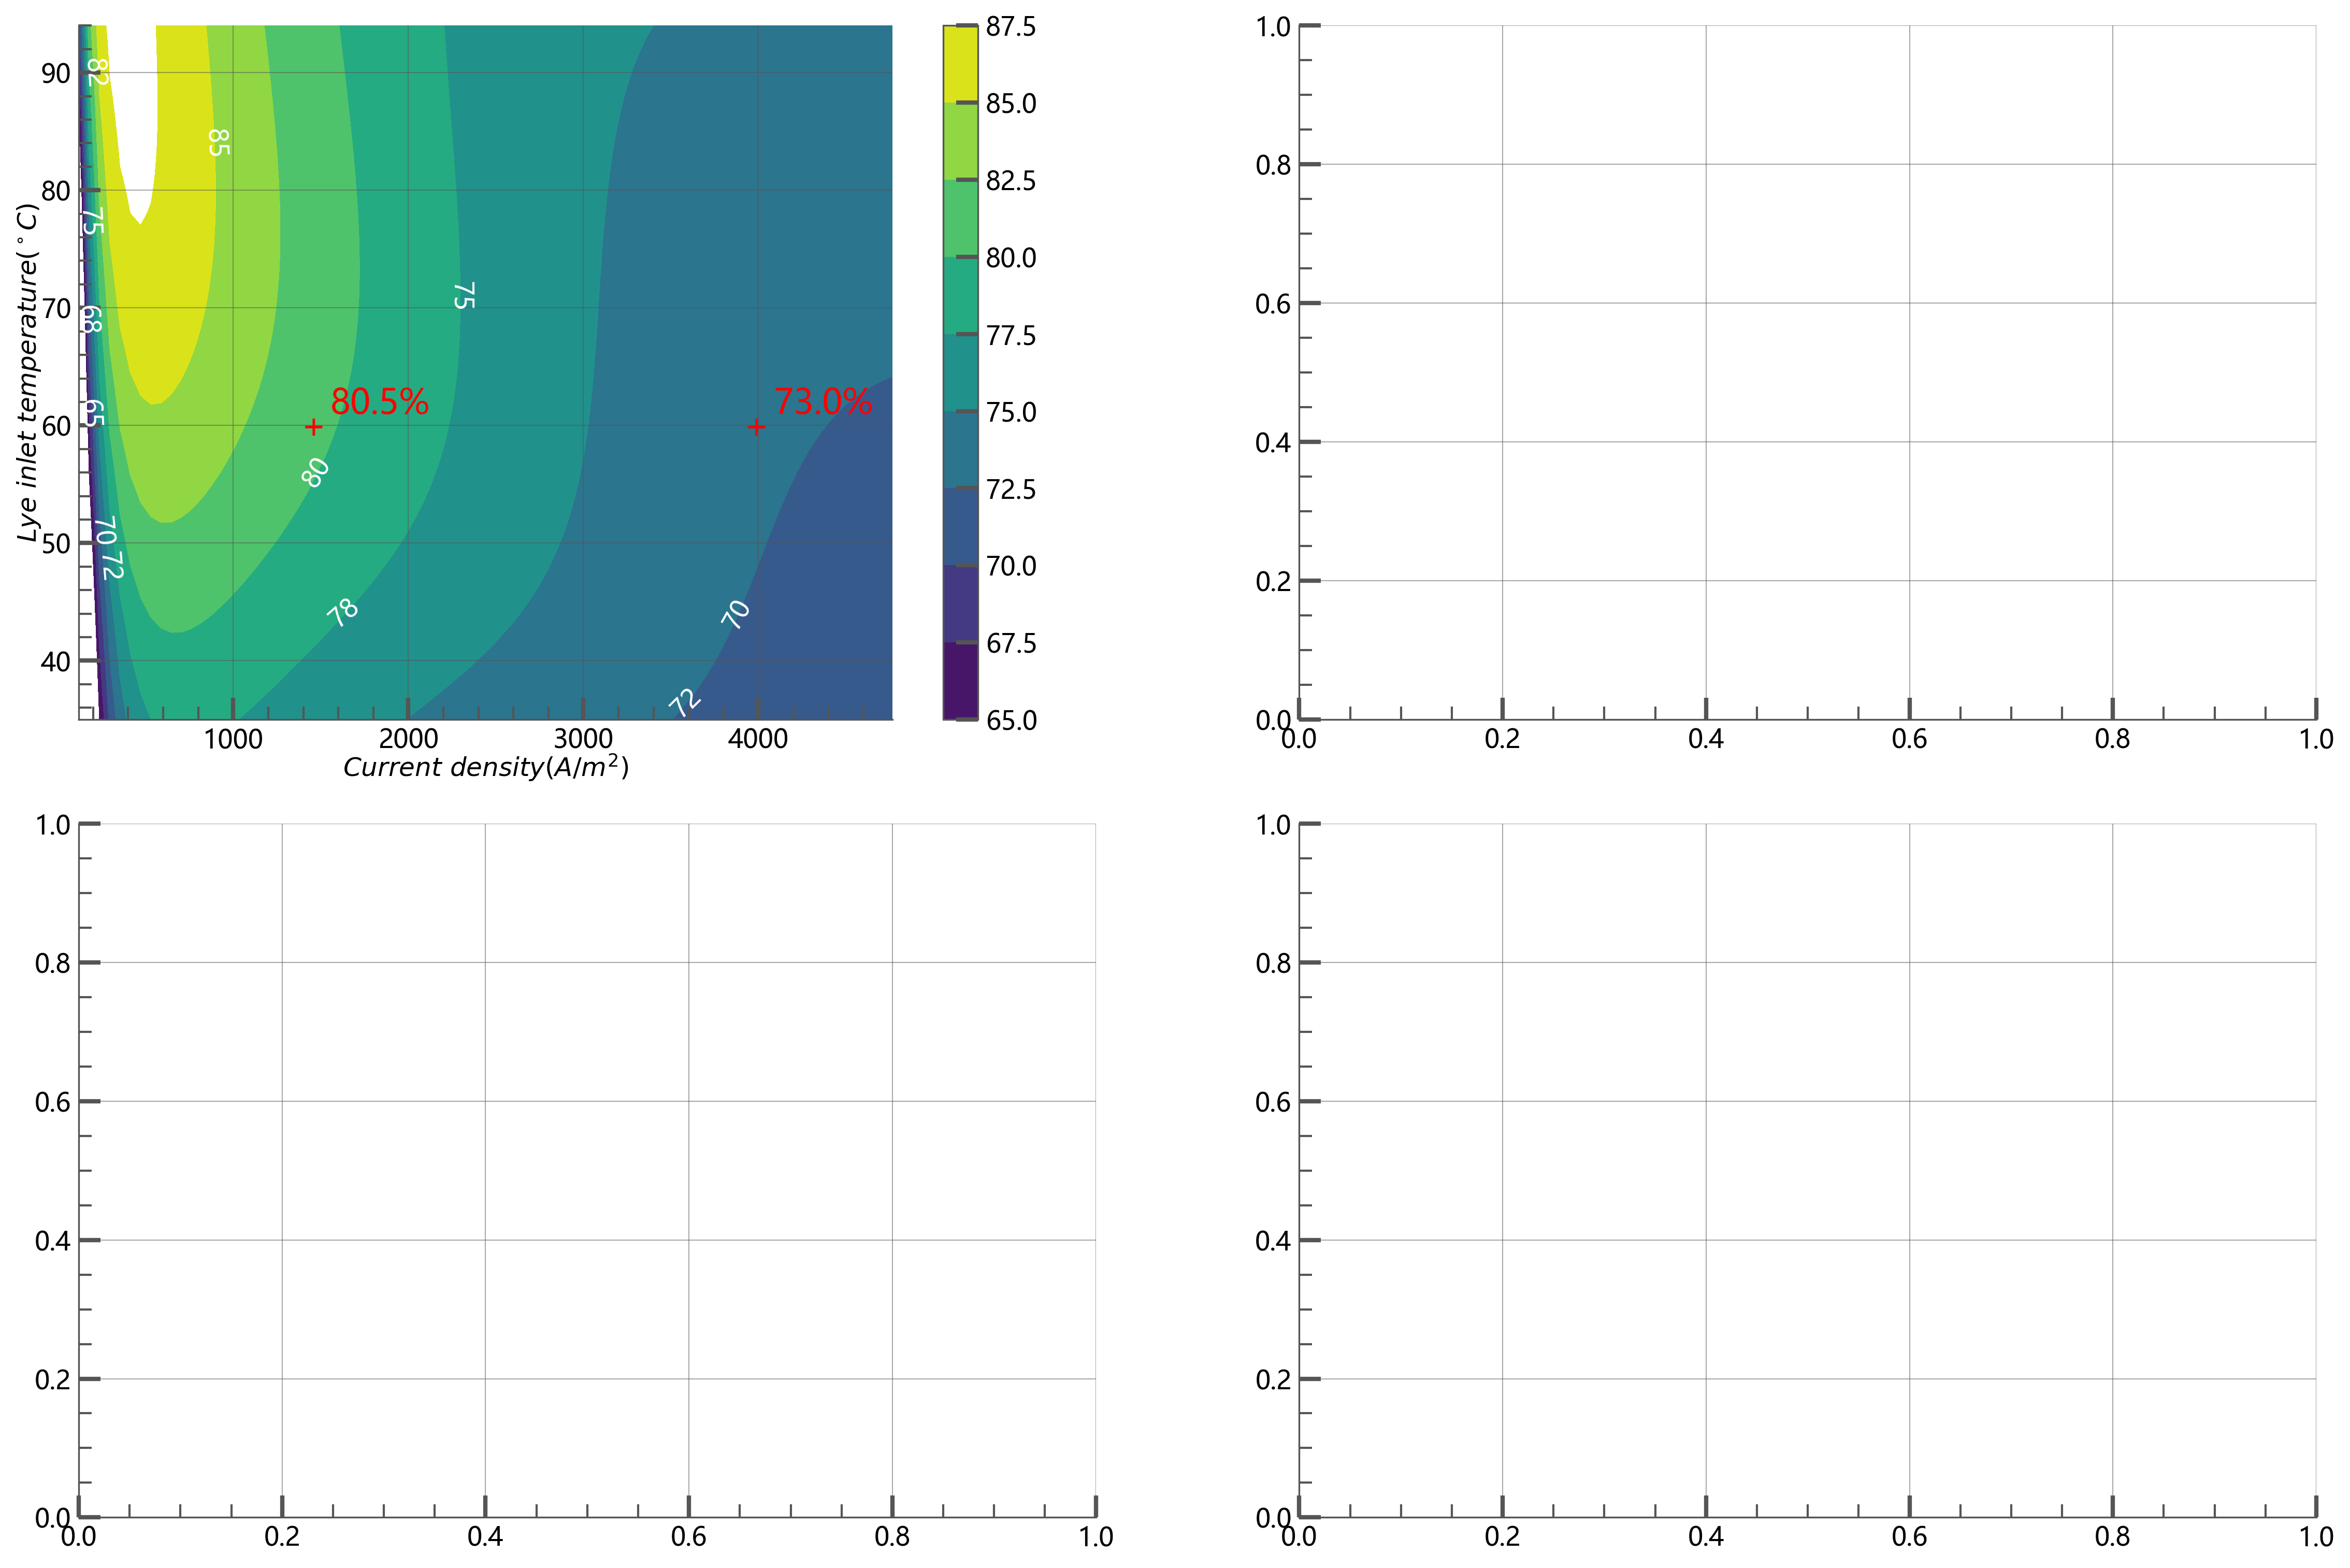

In [9]:
Model_efficiency_hydrogen_cost().save()